## Testing Unet

## Image loading

In [1]:
from data_loader import *
device = torch.device("cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu"))

Define several core functions


In [2]:
train_dataset = f"dataset/generated_cells"
dataset = SegmentationDataset(train_dataset)
print(f'Load images {train_dataset}: {len(dataset)} ')


img0, msk0 = dataset[0]
print('Check type and size of Torch tensor', type(img0), type(msk0))
print(f'Image[0]  {img0.shape} max: {img0.max():0.7f} max: {img0.min():0.7f} type: {img0.type()}')
print(f'Image[0]  {msk0.shape} max: {msk0.max():0.7f} max: {msk0.min():0.7f} type: {msk0.type()}')

Load images dataset/generated_cells: 102 
Check type and size of Torch tensor <class 'torch.Tensor'> <class 'torch.Tensor'>
Image[0]  torch.Size([1, 256, 256]) max: 1.0000000 max: 0.0000000 type: torch.FloatTensor
Image[0]  torch.Size([256, 256]) max: 1.0000000 max: 0.0000000 type: torch.LongTensor


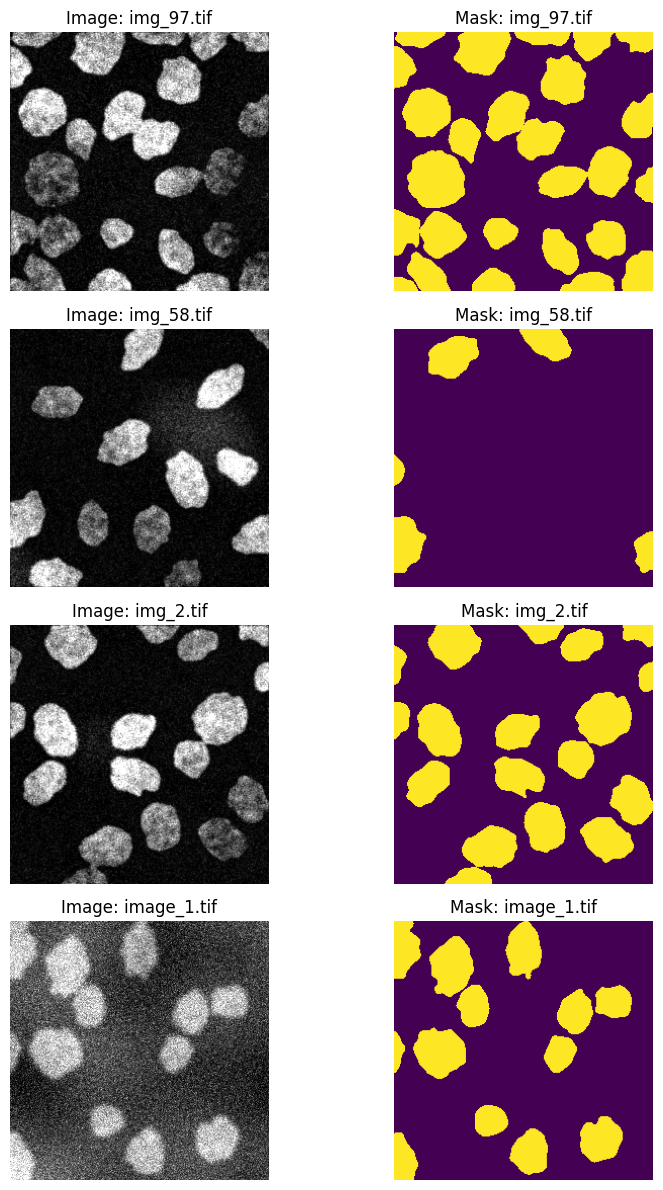

In [3]:
visualization_images(dataset, 4, 2)

In [4]:
val_ratio      = 0.25
batch_size     = 8
full_dataset = SegmentationDataset(train_dataset)
image0, mask0 = full_dataset[0]
print(type(image0))
print(f'Image 0 {image0.shape} max: {np.max(image0.shape)} {image0.type()}')
print(f'Image 0 {mask0.shape} max: {np.max(mask0.shape)} {mask0.type()}')
n_val   = max(1, int(len(full_dataset) * val_ratio))
n_train = len(full_dataset) - n_val

perm = torch.randperm(len(full_dataset)).tolist()
train_dataset = Subset(full_dataset, perm[n_val:])
val_dataset   = Subset(full_dataset, perm[:n_val])

# num_workers=0 avoids PicklingError in notebooks
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

print(f"Number of image in Train: {len(train_dataset)} | Val: {len(val_dataset)}")

<class 'torch.Tensor'>
Image 0 torch.Size([1, 256, 256]) max: 256 torch.FloatTensor
Image 0 torch.Size([256, 256]) max: 256 torch.LongTensor
Number of image in Train: 77 | Val: 25


In [9]:
import model
num_classes = 2
model = model.UNet(n_channels=1, n_classes=num_classes, first_layer_size=16, depth=2)

pretrained_model_name = None 

if pretrained_model_name != None:
    ckpt = torch.load(pretrained_model_name, map_location="cpu")
    # If it was trained with DataParallel and keys start with "module.", strip the prefix:
    if isinstance(ckpt, dict) and len(ckpt) and next(iter(ckpt)).startswith("module."):
        ckpt = {k.replace("module.", "", 1): v for k, v in ckpt.items()}
    print('Checkpoints of the preload_model {pretrained_weigths}', len(ckpt))
    model.load_state_dict(ckpt, strict=True) 

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"UNet: {num_params} number of trainable parameters of model ")
print(f'Pretrained model: {pretrained_model_name}' )

UNet: 117090 number of trainable parameters of model 
Pretrained model: None


In [7]:
def binary_iou(img_true,img_pred):
    intersection = np.sum(np.multiply(img_true,img_pred))
    union = np.count_nonzero(img_true + img_pred)

    return intersection/union

<generator object _BaseKFold.split at 0x7f24ec6add60>

[Fold 1]
SHAPE IS torch.Size([8, 1, 256, 256]) torch.Size([8, 1, 256, 256])
SHAPE IS torch.Size([8, 1, 256, 256]) torch.Size([8, 1, 256, 256])
SHAPE IS torch.Size([8, 1, 256, 256]) torch.Size([8, 1, 256, 256])
SHAPE IS torch.Size([8, 1, 256, 256]) torch.Size([8, 1, 256, 256])
SHAPE IS torch.Size([8, 1, 256, 256]) torch.Size([8, 1, 256, 256])
SHAPE IS torch.Size([8, 1, 256, 256]) torch.Size([8, 1, 256, 256])
SHAPE IS torch.Size([3, 1, 256, 256]) torch.Size([3, 1, 256, 256])
Fold 1 | Epoch 1/100 Train Loss: 0.7053 | Val Loss: 0.6710 | IoU: 0.0000


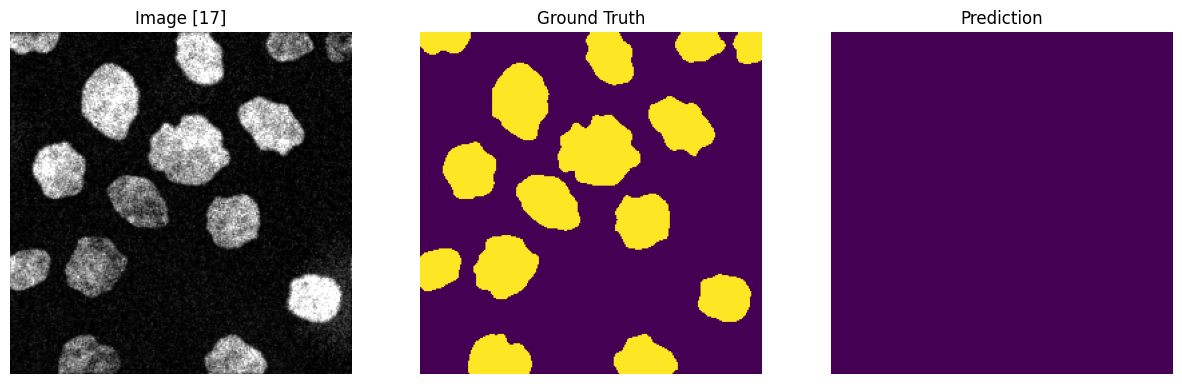

SHAPE IS torch.Size([8, 1, 256, 256]) torch.Size([8, 1, 256, 256])
SHAPE IS torch.Size([8, 1, 256, 256]) torch.Size([8, 1, 256, 256])
SHAPE IS torch.Size([8, 1, 256, 256]) torch.Size([8, 1, 256, 256])
SHAPE IS torch.Size([8, 1, 256, 256]) torch.Size([8, 1, 256, 256])
SHAPE IS torch.Size([8, 1, 256, 256]) torch.Size([8, 1, 256, 256])
SHAPE IS torch.Size([8, 1, 256, 256]) torch.Size([8, 1, 256, 256])
SHAPE IS torch.Size([3, 1, 256, 256]) torch.Size([3, 1, 256, 256])
Fold 1 | Epoch 2/100 Train Loss: 0.6269 | Val Loss: 0.6611 | IoU: 0.0000
SHAPE IS torch.Size([8, 1, 256, 256]) torch.Size([8, 1, 256, 256])
SHAPE IS torch.Size([8, 1, 256, 256]) torch.Size([8, 1, 256, 256])
SHAPE IS torch.Size([8, 1, 256, 256]) torch.Size([8, 1, 256, 256])
SHAPE IS torch.Size([8, 1, 256, 256]) torch.Size([8, 1, 256, 256])
SHAPE IS torch.Size([8, 1, 256, 256]) torch.Size([8, 1, 256, 256])
SHAPE IS torch.Size([8, 1, 256, 256]) torch.Size([8, 1, 256, 256])
SHAPE IS torch.Size([3, 1, 256, 256]) torch.Size([3, 1, 

KeyboardInterrupt: 

In [9]:
import os
import numpy as np
from skimage import io, util
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
from model import UNet
from sklearn.model_selection import KFold
from sklearn.metrics import jaccard_score

import matplotlib.pyplot as plt

train_dataset = f"dataset/generated_cells"
dataset = SegmentationDataset(train_dataset)
learning_rate = 1e-5
batch_size = 10
num_epochs = 100

kf = KFold(n_splits=2, shuffle=True, random_state=42)
fold = 1
indices = np.arange(len(dataset))
print(kf.split(indices))
for train_index, valid_index in kf.split(indices):  # pass the list, not a string
    print(f"\n[Fold {fold}]")
    
    train_dataset = Subset(dataset, train_index)
    valid_dataset = Subset(dataset, valid_index)
    
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=8)


    model = UNet(n_channels=1, n_classes=1, first_layer_size=16, depth=2).to(device)
    


    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.BCEWithLogitsLoss()

    train_losses = []
    val_losses = []
    val_ious = []

    index_img_printed = np.random.randint(0,len(valid_dataset))
    for epoch in range(num_epochs):
        model.train()
        running = 0.0

        for imgs, msks in train_loader:
            imgs, msks = imgs.to(device), msks.to(device).float()
            msks = msks.unsqueeze(1)

            optimizer.zero_grad()
            out = model(imgs)
            print("SHAPE IS",out.shape, imgs.shape)
            loss = criterion(out, msks)
            loss.backward()
            optimizer.step()

            running += loss.item() * imgs.size(0)

        tr_loss = running / len(train_dataset)
        train_losses.append(tr_loss)

        model.eval()
        val_running = 0.0
        iou_running = 0.0

        with torch.no_grad():
            for imgs, msks in valid_loader:
                imgs, msks = imgs.to(device), msks.to(device).float()
                msks = msks.unsqueeze(1)
                out = model(imgs)

                vloss = criterion(out, msks)
                val_running += vloss.item() * imgs.size(0)

                pred = torch.sigmoid(out)
                pred = (pred > 0.5).float()

                iou_running += jaccard_score(
                    msks.cpu().numpy().reshape(-1),
                    pred.cpu().numpy().reshape(-1)
                )

                #iou_running += binary_iou(msks.cpu().numpy(),pred.cpu().numpy())

        va_loss = val_running / len(valid_dataset)
        va_iou = iou_running / len(valid_loader)

        val_losses.append(va_loss)
        val_ious.append(va_iou)

        print(f"Fold {fold} | Epoch {epoch+1}/{num_epochs} "
              f"Train Loss: {tr_loss:.4f} | Val Loss: {va_loss:.4f} | IoU: {va_iou:.4f}")
        if epoch % 10 == 0:
            visualize_prediction(model, train_dataset, device, sample_idx=index_img_printed)

    
    epochs_range = range(1, num_epochs + 1)

    plt.figure(figsize=(10,5))
    plt.plot(epochs_range, train_losses, label="Train Loss")
    plt.plot(epochs_range, val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Fold {fold} – Loss Curves")
    plt.legend()
    plt.show()

    plt.figure(figsize=(10,5))
    plt.plot(epochs_range, val_ious, label="Val IoU")
    plt.xlabel("Epoch")
    plt.ylabel("IoU")
    plt.title(f"Fold {fold} – IoU Curve")
    plt.legend()
    plt.show()

    

    fold += 1


In [9]:
def visualize_prediction1(model, subset, device, sample_idx=0): # DO NOT RUN
    model.eval()
    with torch.no_grad():
        img, msk = subset[sample_idx]

        # prepare input
        inp = img.unsqueeze(0).to(device)  # [1,1,H,W]
        logits = model(inp)                # [1,1,H,W]

        # convert logits → probabilities → binary mask
        prob = torch.sigmoid(logits)[0,0].cpu().numpy()    # [H,W]
        pred = (prob > 0.5).astype(np.uint8)               # [H,W]

        # get raw image
        img_show = img.squeeze(0).cpu().numpy()
        msk_show = msk.squeeze().cpu().numpy()

        # plot
        plt.figure(figsize=(15,5))
        plt.subplot(1,3,1); plt.imshow(img_show, cmap='gray'); plt.title("Image"); plt.axis("off")
        plt.subplot(1,3,2); plt.imshow(msk_show, cmap='gray'); plt.title("Ground Truth"); plt.axis("off")
        plt.subplot(1,3,3); plt.imshow(pred, cmap='gray'); plt.title("Prediction"); plt.axis("off")
        plt.show()

Using device: cuda
Starting training for 100 epochs...
Epoch [1/100]  train_loss: 3.1855  val_loss: 2.6859 iou:0.5087  time: 2.45s lr: 1.00E-03


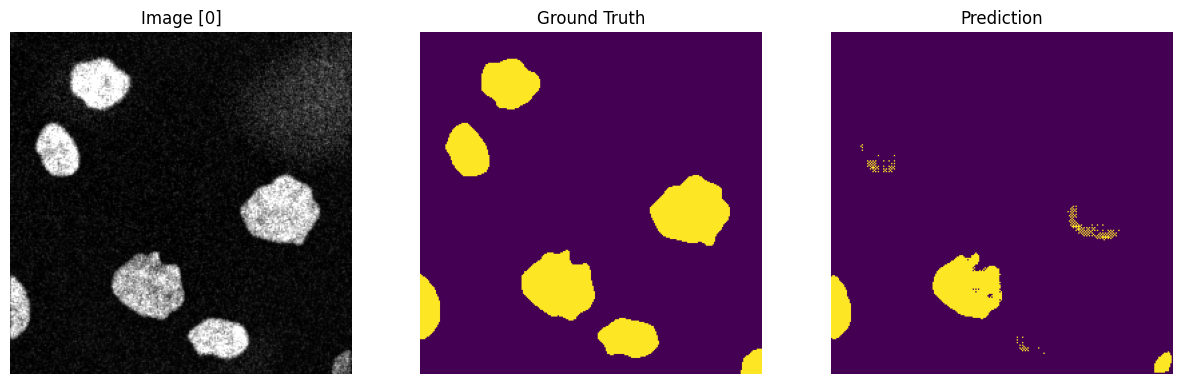

Epoch [2/100]  train_loss: 2.2540  val_loss: 6.8653 iou:0.1072  time: 2.30s lr: 1.00E-03
Epoch [3/100]  train_loss: 1.9154  val_loss: 1.6587 iou:0.6668  time: 2.40s lr: 1.00E-03
Epoch [4/100]  train_loss: 1.7377  val_loss: 1.4530 iou:0.7499  time: 2.41s lr: 1.00E-03
Epoch [5/100]  train_loss: 1.4845  val_loss: 1.3536 iou:0.8545  time: 2.44s lr: 1.00E-03
Epoch [6/100]  train_loss: 1.2206  val_loss: 0.9345 iou:0.9417  time: 2.44s lr: 1.00E-03
Epoch [7/100]  train_loss: 1.1354  val_loss: 1.0433 iou:0.9296  time: 2.45s lr: 1.00E-03
Epoch [8/100]  train_loss: 1.0601  val_loss: 1.1237 iou:0.7926  time: 2.41s lr: 1.00E-03
Epoch [9/100]  train_loss: 0.9489  val_loss: 0.4598 iou:0.9598  time: 2.43s lr: 1.00E-03
Epoch [10/100]  train_loss: 0.8548  val_loss: 0.4798 iou:0.9549  time: 2.45s lr: 1.00E-03
Epoch [11/100]  train_loss: 0.8063  val_loss: 0.4036 iou:0.9616  time: 2.50s lr: 1.00E-03


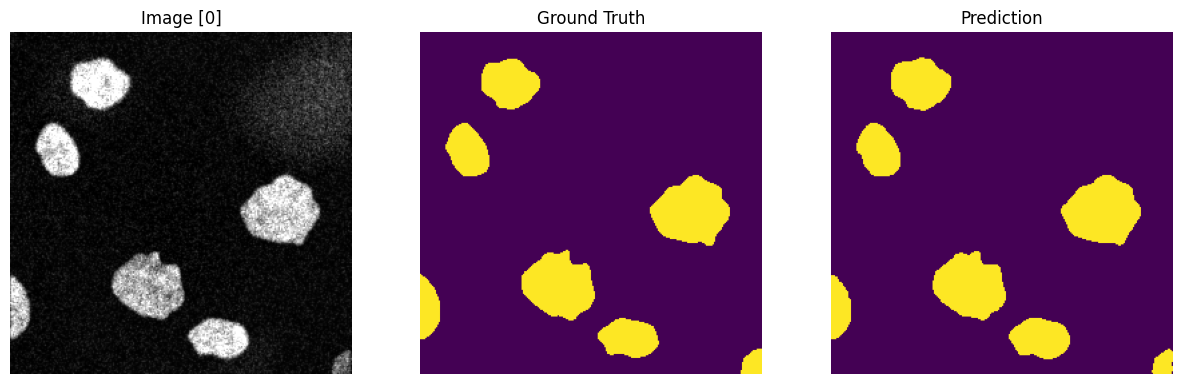

Epoch [12/100]  train_loss: 1.0100  val_loss: 2.1438 iou:0.4535  time: 2.75s lr: 1.00E-03
Epoch [13/100]  train_loss: 0.8180  val_loss: 1.6458 iou:0.5724  time: 2.40s lr: 4.00E-04
Epoch [14/100]  train_loss: 0.7317  val_loss: 0.4452 iou:0.9551  time: 2.52s lr: 1.60E-04
Epoch [15/100]  train_loss: 0.7486  val_loss: 0.4148 iou:0.9619  time: 2.46s lr: 1.60E-04
Epoch [16/100]  train_loss: 0.7620  val_loss: 0.3815 iou:0.9660  time: 2.44s lr: 1.60E-04
Epoch [17/100]  train_loss: 0.7012  val_loss: 0.3886 iou:0.9646  time: 2.37s lr: 1.60E-04
Epoch [18/100]  train_loss: 0.7165  val_loss: 0.3661 iou:0.9650  time: 2.39s lr: 6.40E-05
Epoch [19/100]  train_loss: 0.7120  val_loss: 0.3598 iou:0.9660  time: 2.47s lr: 2.56E-05
Epoch [20/100]  train_loss: 0.6885  val_loss: 0.3523 iou:0.9664  time: 2.47s lr: 2.56E-05
Epoch [21/100]  train_loss: 0.7129  val_loss: 0.3525 iou:0.9666  time: 2.45s lr: 1.02E-05


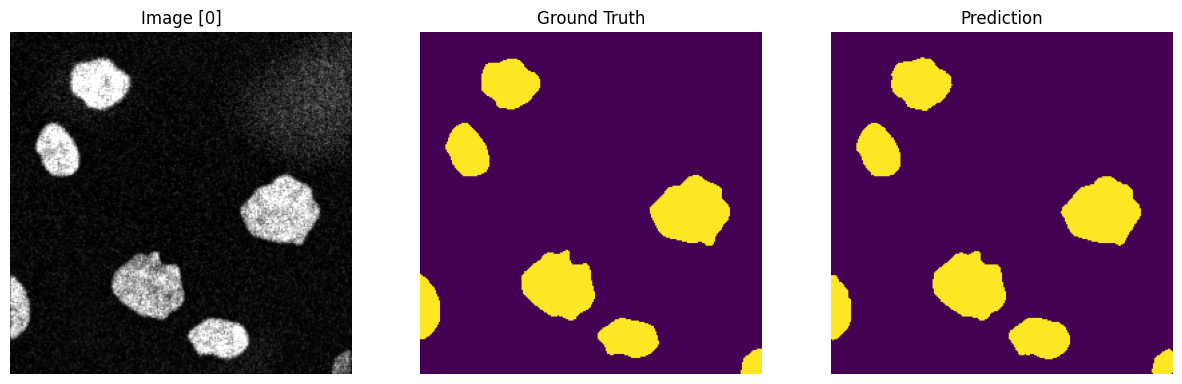

Epoch [22/100]  train_loss: 0.6782  val_loss: 0.3517 iou:0.9666  time: 2.53s lr: 4.10E-06
Epoch [23/100]  train_loss: 0.6815  val_loss: 0.3480 iou:0.9664  time: 2.46s lr: 1.64E-06
Epoch [24/100]  train_loss: 0.6854  val_loss: 0.3510 iou:0.9667  time: 2.39s lr: 6.55E-07
Epoch [25/100]  train_loss: 0.7788  val_loss: 0.3507 iou:0.9667  time: 2.52s lr: 2.62E-07
Epoch [26/100]  train_loss: 0.7201  val_loss: 0.3511 iou:0.9668  time: 2.54s lr: 2.62E-07
Epoch [27/100]  train_loss: 0.6860  val_loss: 0.3517 iou:0.9669  time: 2.53s lr: 1.05E-07
Epoch [28/100]  train_loss: 0.6802  val_loss: 0.3505 iou:0.9668  time: 2.44s lr: 1.05E-07
Epoch [29/100]  train_loss: 0.7171  val_loss: 0.3472 iou:0.9664  time: 2.47s lr: 4.19E-08
Epoch [30/100]  train_loss: 0.7029  val_loss: 0.3480 iou:0.9665  time: 2.52s lr: 1.68E-08
Epoch [31/100]  train_loss: 0.6879  val_loss: 0.3498 iou:0.9666  time: 2.46s lr: 6.71E-09


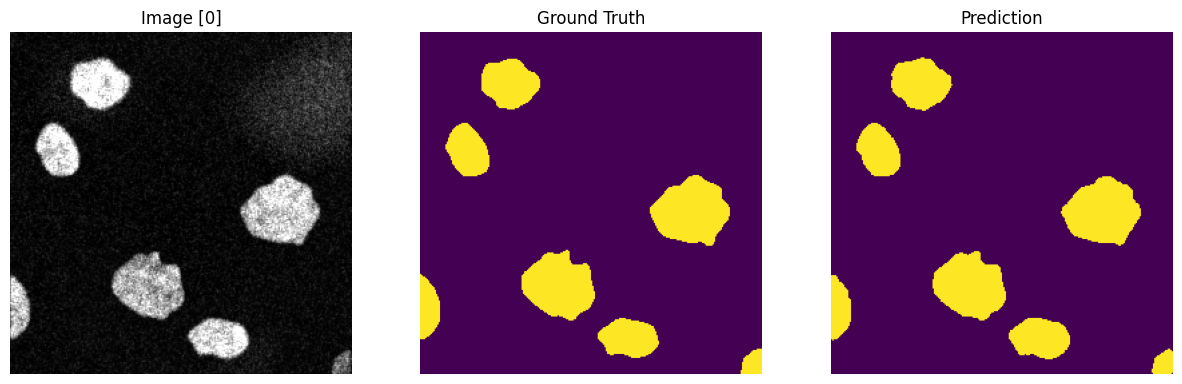

Total time : 77.153677s


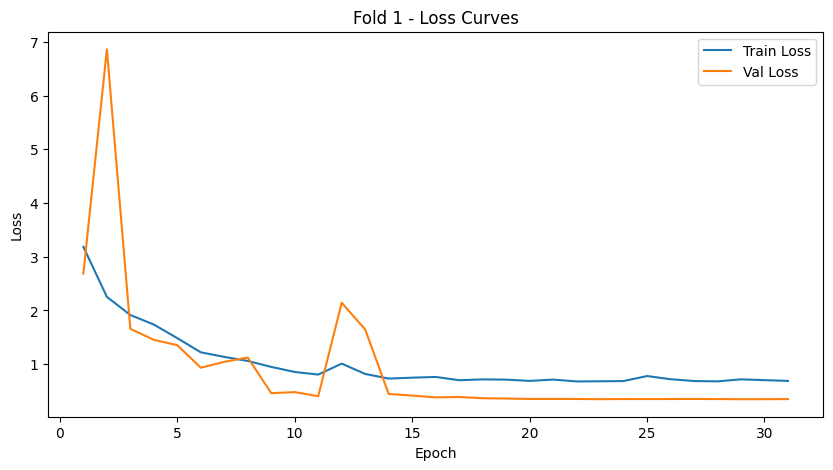

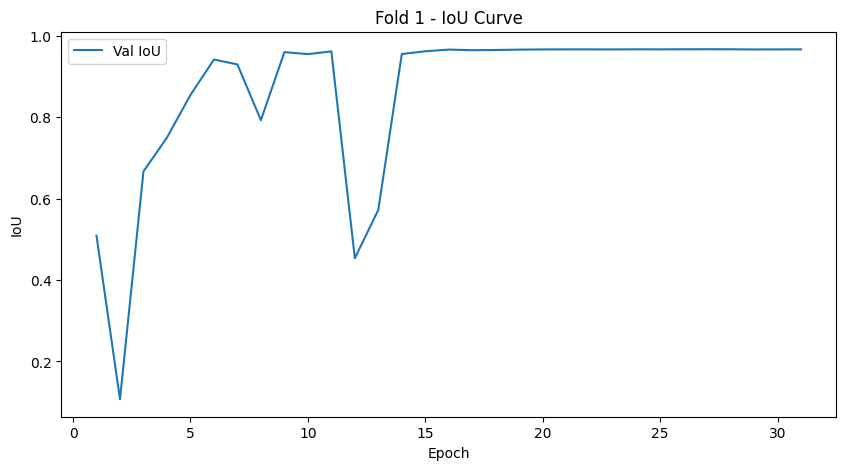

In [ ]:
from model import UNet

train_dataset_path = f"dataset/generated_cells"

val_ratio      = 0.25
batch_size     = 8
full_dataset = SegmentationDataset(train_dataset_path)

n_val   = max(1, int(len(full_dataset) * val_ratio))
n_train = len(full_dataset) - n_val

perm = torch.randperm(len(full_dataset)).tolist()
train_dataset = Subset(full_dataset, perm[n_val:])
val_dataset   = Subset(full_dataset, perm[:n_val])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)


num_epochs   = 100
snapshot     = max(1, num_epochs // 10)
model = UNet(n_channels=1, n_classes=1, first_layer_size=64, depth=4).to(device)
start_time = time.time()

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, factor=0.4)
print(f"Using device: {device}")

model.to(device)
print(f"Starting training for {num_epochs} epochs...")
done_epochs = 0
train_losses, val_losses, val_ious = [], [], []
for epoch in range(num_epochs):
    done_epochs += 1
    start_epoch_time = time.time()
    model.train()
    running = 0.0
    if torch.cuda.is_available(): torch.cuda.reset_peak_memory_stats()
    for imgs, msks in train_loader:
        imgs, msks = imgs.to(device, non_blocking=True), msks.to(device, non_blocking=True).float()
        optimizer.zero_grad(set_to_none=True)
        msks = msks.unsqueeze(1)
        loss = criterion(model(imgs), msks)
        loss.backward()
        scheduler.step(loss)
        optimizer.step()
        running += loss.item() * imgs.size(0)
    tr_loss = running / len(train_loader)
    train_losses.append(tr_loss)

    model.eval()
    val_running = 0.0
    iou_running = 0.0
    with torch.no_grad():
        for imgs, msks in val_loader:
            imgs, msks = imgs.to(device), msks.to(device).float()
            msks = msks.unsqueeze(1)
            out = model(imgs)

            vloss = criterion(out, msks)
            val_running += vloss.item() * imgs.size(0)

            pred = torch.sigmoid(out)
            pred = (pred > 0.5).float()

            iou_running += jaccard_score(
                msks.cpu().numpy().reshape(-1),
                pred.cpu().numpy().reshape(-1)
            )
    va_loss = val_running / len(val_loader)
    va_iou = iou_running / len(val_loader)
    val_losses.append(va_loss)
    val_ious.append(va_iou)
    print(f"Epoch [{epoch+1}/{num_epochs}]  train_loss: {tr_loss:.4f}  val_loss: {va_loss:.4f} iou:{va_iou:.4f}  time: {time.time() - start_epoch_time:.2f}s lr: {scheduler.get_last_lr()[0]:.2E}")

    # ---- snapshot every N/10 epochs on the first training sample
    if epoch % 10 == 0:
        visualize_prediction(model, train_dataset, device, sample_idx=0)

    if scheduler.get_last_lr()[0] < 1e-8:
        break
        

print(f"Total time : {time.time() - start_time:2f}s")
epochs_range = range(1, done_epochs + 1)

plt.figure(figsize=(10,5))
plt.plot(epochs_range, train_losses, label="Train Loss")
plt.plot(epochs_range, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(f"Fold {fold} - Loss Curves")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(epochs_range, val_ious, label="Val IoU")
plt.xlabel("Epoch")
plt.ylabel("IoU")
plt.title(f"Fold {fold} - IoU Curve")
plt.legend()
plt.show()
        

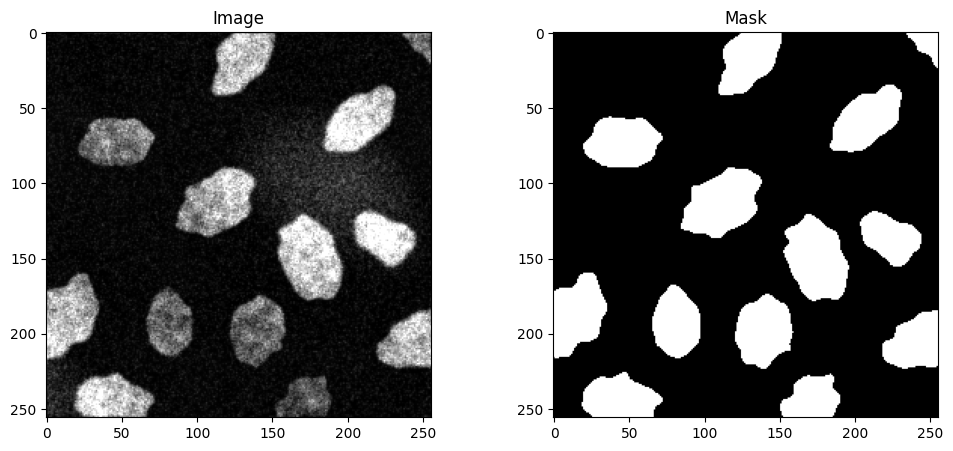

In [3]:
img, msk = dataset[0]
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title("Image")
plt.imshow(img[0], cmap='gray')
plt.subplot(1,2,2)
plt.title("Mask")
plt.imshow(msk, cmap='gray')
plt.show()

In [6]:
print(msk.min(), msk.max())
print(msk.unique()[:10])
print(msk.dtype)

tensor(0) tensor(1)
tensor([0, 1])
torch.int64


In [8]:
img, msk = dataset[0]
print("Image:", img.min().item(), img.max().item(), img.dtype)
print("Mask: ", msk.min().item(), msk.max().item(), msk.dtype)
print("Unique mask values:", torch.unique(msk))

Image: 0.0 1.0 torch.float32
Mask:  0 1 torch.int64
Unique mask values: tensor([0, 1])
